In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite").connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
results

('2017-08-23',)

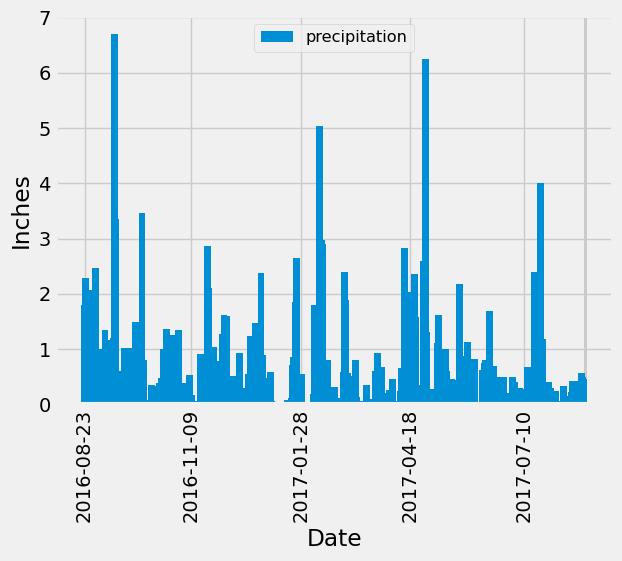

In [10]:
import datetime as dt
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
dates= dt.date(int(str(results)[2:6])-1, int(str(results)[7:9]) ,int(str(results)[10:12]))
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dates).order_by(Measurement.date.desc()).all()

# Calculate the date one year from the last date in data set.
session.query(Measurement.date).\
    filter(Measurement.date >= dates).order_by(Measurement.date).first()

# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_pd=pd.DataFrame(prcp,columns=["Date","Precipitation"])

# Sort the dataframe by date
data_pd.sort_values("Date",ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
y=data_pd.set_index('Date').squeeze()
tick_locations=range(0,len(y))

#creating x-axis ticks and labels
xaxis=pd.Series()
major=pd.Series()
x_id=-1
m_id=0
for x in tick_locations:
    x_id+=1
    if x%500==0:
        xaxis[x_id]=y.index[x]
        major[m_id]=x
        m_id+=1
    else:
        xaxis[x_id]=""
        
#formatting the plot        
precipitation = plt.bar(y.index,y,label="precipitation", width = 5)
plt.legend(handles=[precipitation],loc="upper center",fontsize="small")
plt.xticks(list(xaxis), rotation="vertical")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(visible=True)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_pd.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# session.query(func.distinct(Measurement.station)).count()
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station=list(session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first())[0]
lowest=list(session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station==top_station).first())[0]
highest=list(session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station==top_station).first())[0]
average=list(session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==top_station).first())[0]
[(lowest, highest, average)]


[(54.0, 85.0, 71.66378066378067)]

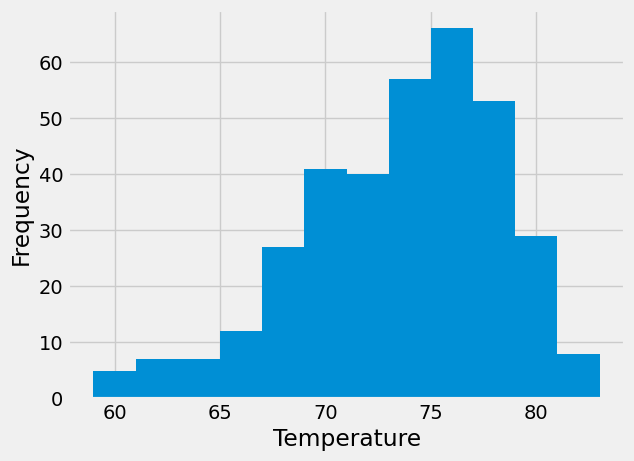

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs1 = session.query(Measurement.tobs).\
    filter(Measurement.date >= dates).filter(Measurement.station==top_station).\
    order_by(Measurement.date.desc()).all()
tobs2=[]
for row in tobs1:
    tobs2.append(row[0])

plt.hist(tobs2,bins=12,label="tobs")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()